# <div align="center"> Utilizing SVM and CNN Models for Breast Cancer Detection with Mammography and Ultrasound Imaging </div>

Group 5:
* Almira Zahra Aurelia – 00000080298
* Darren Irawan Djong – 00000081041
* Kayla Abigail Gunawan – 00000081824
* Sabrina Fajrul Ula Usman – 00000083124

# Breast Cancer Ultrasound with SVM 

# Prepare and Collect Data

In [34]:
import os

data_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/image ml/Dataset_BUSI_with_GT"
benign_path = os.path.join(data_path, "benign")
malignant_path = os.path.join(data_path, "malignant")
normal_path = os.path.join(data_path, "normal")

In [35]:
import cv2
from tqdm import tqdm

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder_path)):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (100, 100))  # Resize the image as needed
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error occurred while processing image {img_path}: {e}")
    return images, labels

In [36]:
benign_images, benign_labels = load_images(benign_path, "benign")
malignant_images, malignant_labels = load_images(malignant_path, "malignant")
normal_images, normal_labels = load_images(normal_path, "normal")

100%|██████████| 133/133 [00:01<00:00, 80.05it/s]


In [37]:
all_images = benign_images + malignant_images + normal_images
all_labels = benign_labels + malignant_labels + normal_labels

In [38]:
import numpy as np

X = np.array(all_images)
y = np.array(all_labels)

In [39]:
np.unique(y)

array(['benign', 'malignant', 'normal'], dtype='<U9')

In [40]:
import pandas as pd

pd.Series(y).value_counts()

benign       437
malignant    210
normal       133
Name: count, dtype: int64

In [41]:
X.shape

(780, 100, 100, 3)

In [42]:
y.shape

(780,)

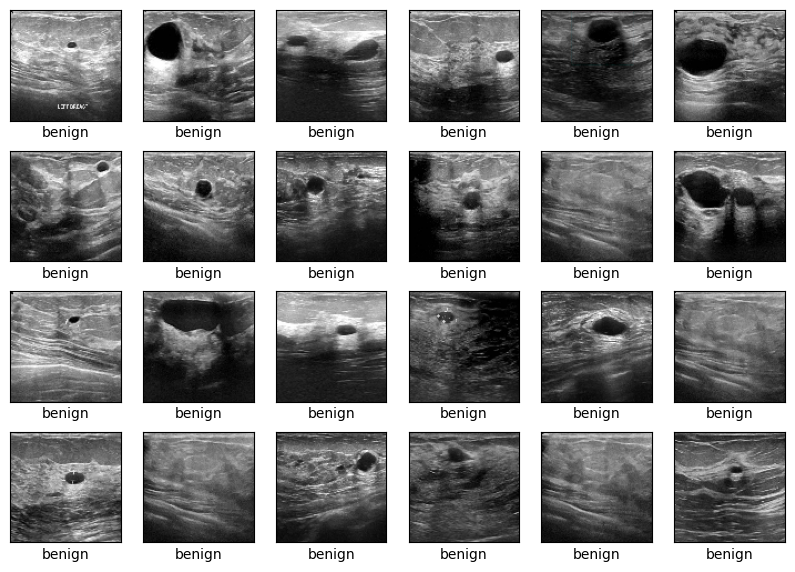

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 6, figsize=(10, 7))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=y[i])

In [44]:
X = X.reshape(len(X), -1)
y = y.reshape(len(X), -1)

X.shape, y.shape

((780, 30000), (780, 1))

# Split Data

In [45]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=10, 
                                                test_size=.20)

In [46]:
Xtrain.shape, Xtest.shape

((624, 30000), (156, 30000))

# Feature Scalling

In [47]:
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

255 0
255 0


In [48]:
Xtrain = Xtrain/255
Xtest = Xtest/255
print(Xtrain.max(), Xtrain.min())
print(Xtest.max(), Xtest.min())

1.0 0.0
1.0 0.0


# Feature Selection

In [49]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
model = make_pipeline(pca, svc)

# Train Model

In [50]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50, 100, 200],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005, 0.01, 0.1]}
grid = GridSearchCV(model, param_grid, cv=5)

%time grid.fit(Xtrain, ytrain)

CPU times: total: 18min 53s
Wall time: 4min 9s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, whiten=True)),
                                       ('svc',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             param_grid={'svc__C': [1, 5, 10, 50, 100, 200],
                         'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005, 0.01,
                                        0.1]})

In [51]:
print(grid.best_params_)

{'svc__C': 100, 'svc__gamma': 0.01}


In [52]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

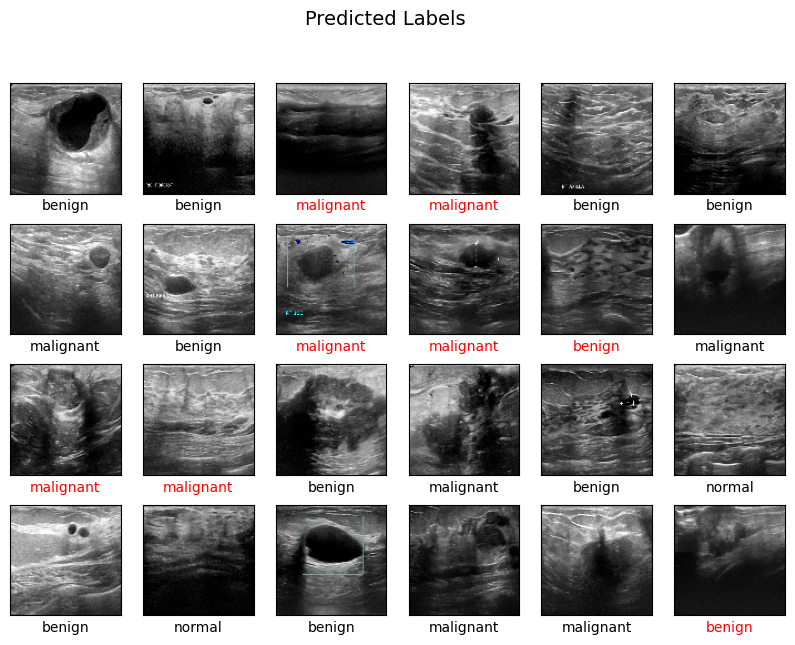

In [53]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))
# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [54]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 624
Jumlah sampel data pengujian: 156


# Evaluation

In [55]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.81      0.67      0.73        92
   malignant       0.58      0.79      0.67        48
      normal       0.54      0.44      0.48        16

    accuracy                           0.69       156
   macro avg       0.64      0.63      0.63       156
weighted avg       0.71      0.69      0.69       156



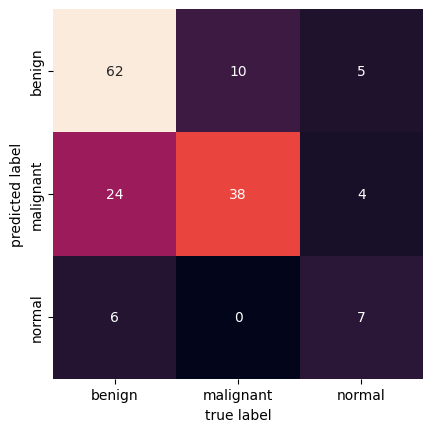

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [57]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9983974358974359
Testing Score: 0.6858974358974359


# K-FOLD CROSS VALIDATION

In [58]:
from sklearn.model_selection import cross_val_score
k_fold_acc = cross_val_score(model, Xtrain, ytrain, cv=10)
k_fold_mean = k_fold_acc.mean()

In [59]:
k_fold_acc

array([0.73015873, 0.68253968, 0.77777778, 0.73015873, 0.77419355,
       0.69354839, 0.72580645, 0.66129032, 0.72580645, 0.64516129])

In [60]:
k_fold_mean

0.7146441372247824

# Stratified KFold CrossVal

In [61]:
from sklearn.model_selection import StratifiedKFold

# Define the number of splits for stratified k-fold cross-validation
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize an empty list to store the cross-validation scores
stratified_k_fold_acc = []

# Iterate over the stratified k-fold splits
for train_index, val_index in skf.split(Xtrain, ytrain):
    # Split the data into training and validation sets
    X_train_fold, X_val_fold = Xtrain[train_index], Xtrain[val_index]
    y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]

    # Fit the model on the training data for this fold
    model.fit(X_train_fold, y_train_fold)

    # Evaluate the model on the validation data for this fold
    fold_score = model.score(X_val_fold, y_val_fold)

    # Append the validation score to the list of cross-validation scores
    stratified_k_fold_acc.append(fold_score)

stratified_k_fold_acc

[0.8095238095238095,
 0.6984126984126984,
 0.6666666666666666,
 0.6984126984126984,
 0.6129032258064516,
 0.6612903225806451,
 0.6935483870967742,
 0.6612903225806451,
 0.6451612903225806,
 0.6774193548387096]

In [62]:
# Calculate the mean accuracy of stratified k-fold cross-validation
stratified_k_fold_mean = np.mean(stratified_k_fold_acc)
stratified_k_fold_mean

0.682462877624168

# NEW QUERY

In [63]:
import joblib

# Menyimpan model ke dalam file
joblib.dump(model, 'UltraSound_SVM2.model')

['UltraSound_SVM2.model']

In [64]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Function to load and preprocess new query images from a specified folder
def load_and_preprocess_new_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (100, 100))  # Resize the image to match training data
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error occurred while processing image {img_path}: {e}")
    return images, labels

# Paths to new query images folders
new_query_benign_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/DATA FOR NEW QUERY/Benign"  
new_query_malignant_path = "C:/Users/Hp/MACHINE LEARNING/Lab/ML PROJECT/DATA FOR NEW QUERY/Malignant"  

# Load and preprocess new query images from both folders
new_query_benign_images, new_query_benign_labels = load_and_preprocess_new_images_from_folder(new_query_benign_path, 'benign')
new_query_malignant_images, new_query_malignant_labels = load_and_preprocess_new_images_from_folder(new_query_malignant_path, 'malignant')

# Combine images and labels from both folders
new_query_images = new_query_benign_images + new_query_malignant_images
new_query_labels = new_query_benign_labels + new_query_malignant_labels

# Convert the list of images to a numpy array and preprocess them
X_new_query = np.array(new_query_images)
X_new_query = X_new_query.reshape(len(X_new_query), -1)  # Flatten images
X_new_query = X_new_query / 255  # Scale the pixel values

# Load the saved model
model = joblib.load('UltraSound_SVM2.model')

# Predict using the trained model
y_new_query_pred = model.predict(X_new_query)

# Reshape the data back to the original shape for visualization
X_new_query_reshaped = X_new_query.reshape((X_new_query.shape[0], 100, 100, 3))

In [65]:
# Calculate and print accuracy
y_true = np.array(new_query_labels)
y_pred = y_new_query_pred

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy on new query images: {accuracy:.2f}')

# Print classification report
print(classification_report(y_true, y_pred, target_names=['benign', 'malignant','normal']))

Accuracy on new query images: 0.59
              precision    recall  f1-score   support

      benign       0.58      0.52      0.55       109
   malignant       0.63      0.65      0.64       123
      normal       0.00      0.00      0.00         0

    accuracy                           0.59       232
   macro avg       0.40      0.39      0.40       232
weighted avg       0.60      0.59      0.60       232



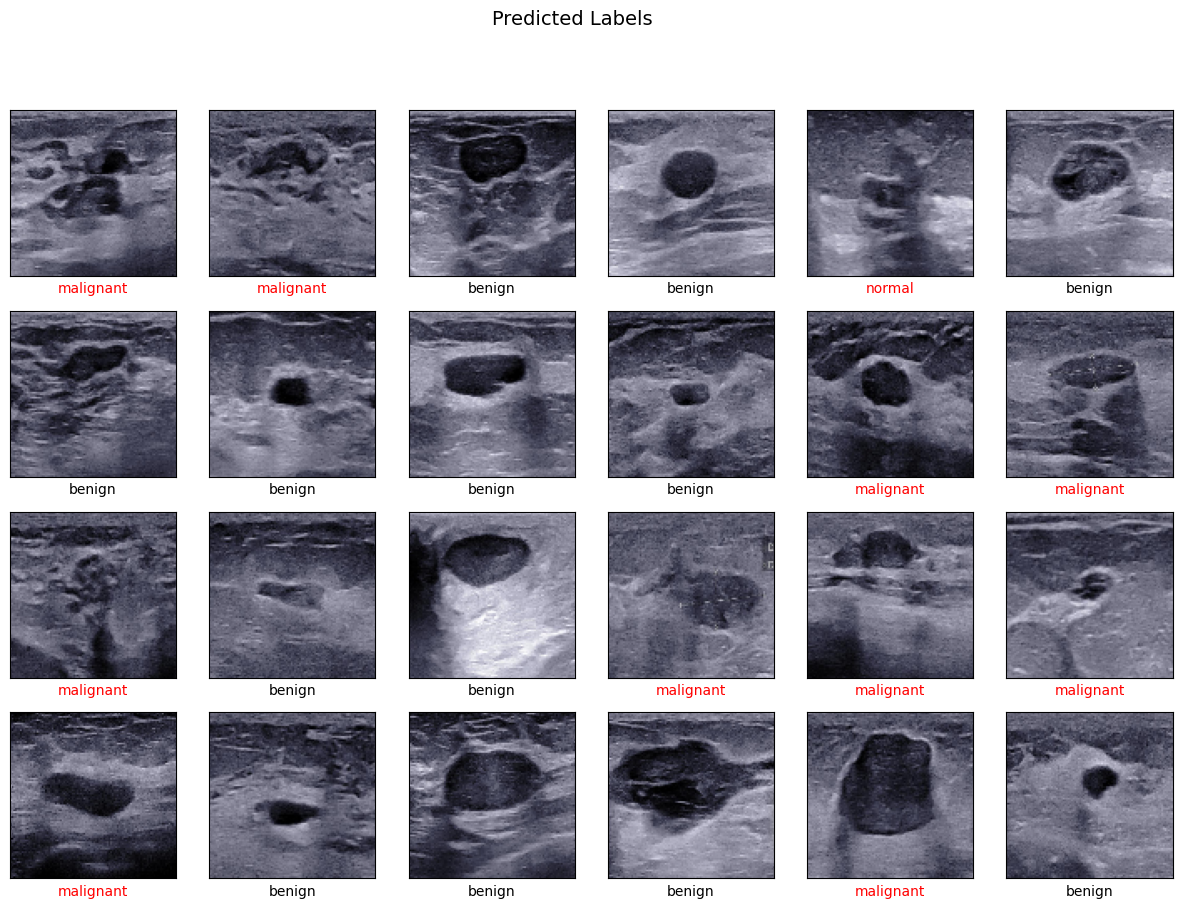

In [66]:
# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(15, 10))

for i, axi in enumerate(ax.flat):
    if i < len(new_query_images):
        axi.imshow(cv2.cvtColor(new_query_images[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        color = 'black' if y_new_query_pred[i] == y_true[i] else 'red'
        axi.set(xticks=[], yticks=[])
        axi.set_xlabel(f'{y_new_query_pred[i]}', color=color)
    else:
        axi.axis('off')

fig.suptitle('Predicted Labels', size=14)
plt.show()

---
# EXPLORING OTHER KERNEL
### TRAIN 2
## Linear

In [35]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='linear', class_weight='balanced')
model = make_pipeline(pca, svc)

In [22]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 37s
Wall time: 3min 7s
{'svc__C': 10, 'svc__gamma': 0.0001}


In [23]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

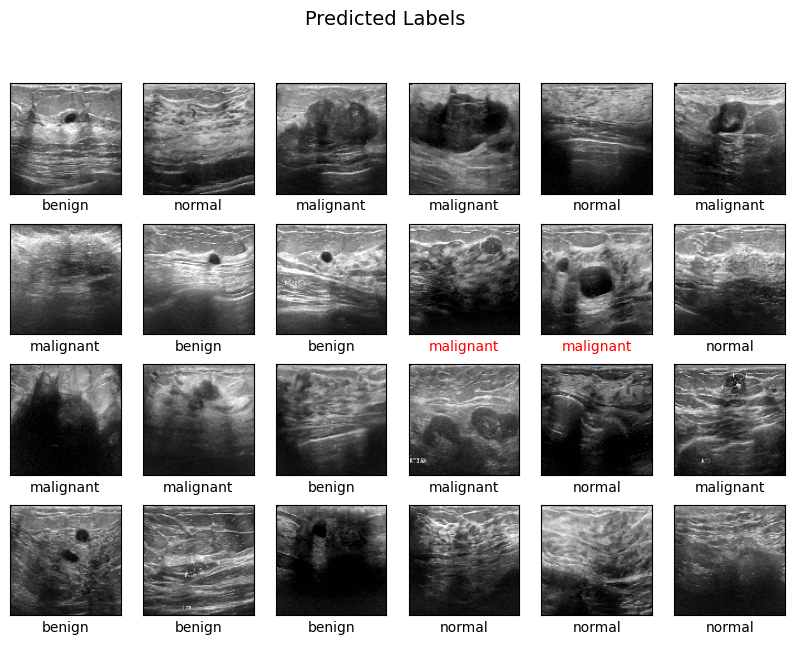

In [24]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [25]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [26]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.76      0.72      0.74        80
   malignant       0.81      0.78      0.79        89
      normal       0.90      1.00      0.95        71

    accuracy                           0.82       240
   macro avg       0.82      0.83      0.83       240
weighted avg       0.82      0.82      0.82       240



In [27]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9791013584117032
Testing Score: 0.825


### TRAIN 3 
### SIGMOID

In [28]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='sigmoid', class_weight='balanced')
model = make_pipeline(pca, svc)

In [29]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 23s
Wall time: 2min 39s
{'svc__C': 50, 'svc__gamma': 0.0005}


In [30]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

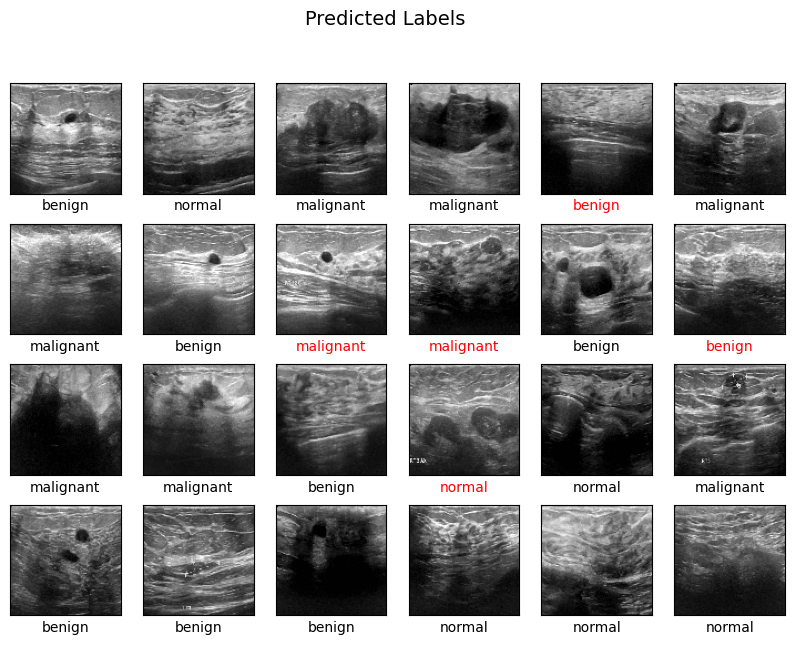

In [31]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [32]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [33]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.56      0.60      0.58        80
   malignant       0.72      0.73      0.73        89
      normal       0.83      0.75      0.79        71

    accuracy                           0.69       240
   macro avg       0.70      0.69      0.70       240
weighted avg       0.70      0.69      0.69       240



In [34]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.8746081504702194
Testing Score: 0.6916666666666667


### TRAIN 3 
### SIGMOID

In [35]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='sigmoid', class_weight='balanced')
model = make_pipeline(pca, svc)

In [36]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 22s
Wall time: 2min 41s
{'svc__C': 50, 'svc__gamma': 0.0005}


In [37]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

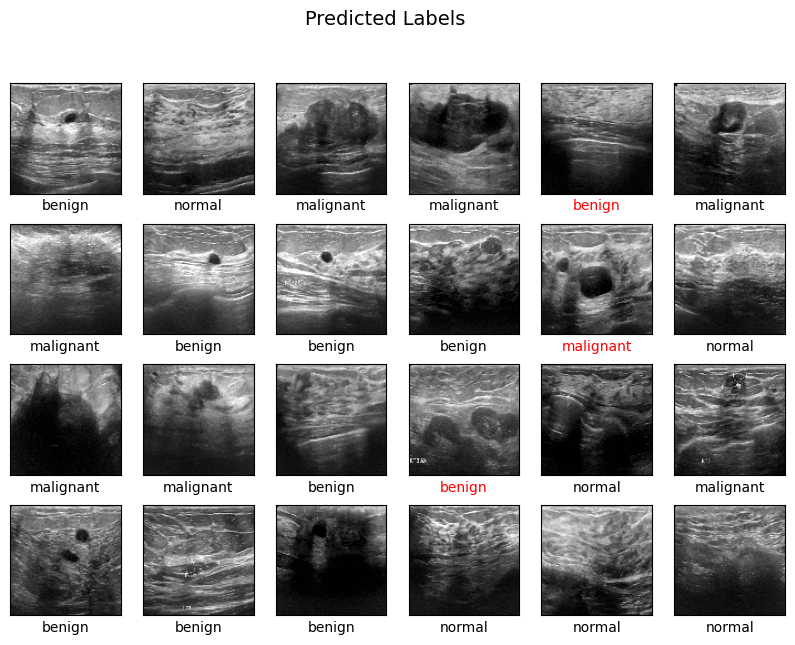

In [38]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [39]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [40]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.60      0.61      0.60        80
   malignant       0.74      0.74      0.74        89
      normal       0.83      0.80      0.81        71

    accuracy                           0.72       240
   macro avg       0.72      0.72      0.72       240
weighted avg       0.72      0.72      0.72       240



In [41]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.8787878787878788
Testing Score: 0.7166666666666667


In [42]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings

# Membuat model dengan PCA dan SVC
def create_pipeline(kernel='rbf'):
    pca = RandomizedPCA(n_components=150, whiten=True)
    svc = SVC(kernel=kernel, class_weight='balanced')
    model = make_pipeline(pca, svc)
    return model

# Mengatur parameter grid untuk setiap kernel
param_grids = {
    'rbf': {'svc__C': [1, 5, 10, 50],
            'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]},
    'sigmoid': {'svc__C': [1, 5, 10, 50],
                'svc__gamma': [0.0001, 0.0005, 0.001, 0.005],
                'svc__coef0': [0.0, 0.1, 0.5, 1.0]},
    'linear': {'svc__C': [1, 5, 10, 50]}
}

# Membuat dan menjalankan GridSearchCV untuk setiap kernel
results = {}
for kernel, param_grid in param_grids.items():
    model = create_pipeline(kernel)
    grid = GridSearchCV(model, param_grid)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid.fit(Xtrain, ytrain)
    results[kernel] = grid

# Menampilkan hasil terbaik untuk setiap kernel
for kernel, grid in results.items():
    print(f"Best parameters for {kernel} kernel: {grid.best_params_}")


Best parameters for rbf kernel: {'svc__C': 5, 'svc__gamma': 0.005}
Best parameters for sigmoid kernel: {'svc__C': 50, 'svc__coef0': 0.1, 'svc__gamma': 0.0005}
Best parameters for linear kernel: {'svc__C': 50}


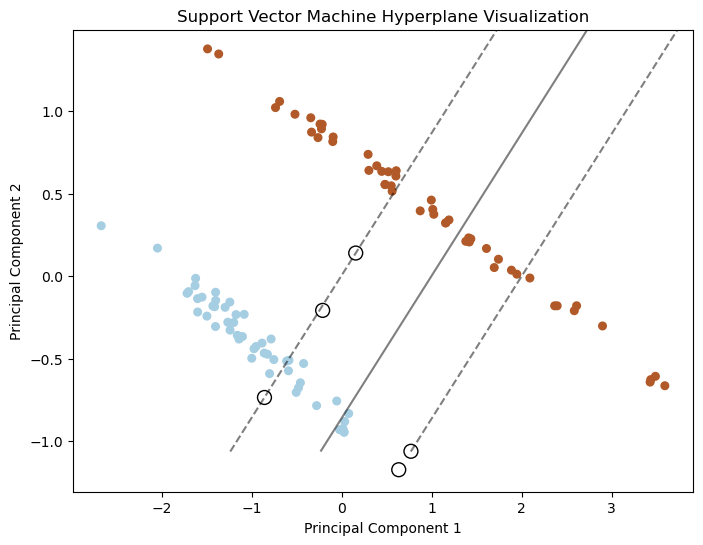

In [43]:
#r
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, 
                            n_informative=2, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane
def plot_hyperplane(X, y, clf):
    plt.figure(figsize=(8, 6))

    # Mengurangi dimensi data ke 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot data point
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Membuat grid untuk menggambar hyperplane
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Visualisasi hyperplane dan margin
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # Menandai support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Support Vector Machine Hyperplane Visualization')
    plt.show()

# Memvisualisasikan hyperplane
plot_hyperplane(X, y, svm)


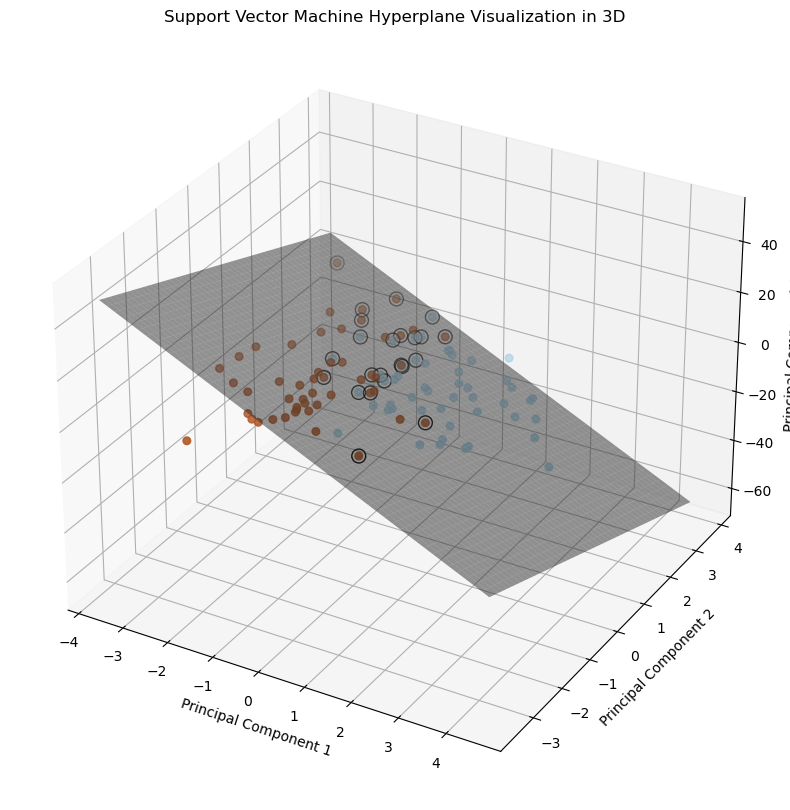

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=3, n_classes=2, n_clusters_per_class=1, 
                            n_informative=3, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM
svm = SVC(kernel='linear')
svm.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane dalam 3 dimensi
def plot_hyperplane_3d(X, y, clf):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    z = (-clf.intercept_[0] - clf.coef_[0][0] * xx - clf.coef_[0][1] * yy) / clf.coef_[0][2]
    ax.plot_surface(xx, yy, z, color='gray', alpha=0.5)

    # Menandai support vectors
    support_vectors = pca.transform(clf.support_vectors_)
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1], support_vectors[:, 2],
               s=100, linewidth=1, facecolors='none', edgecolors='k')

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('Support Vector Machine Hyperplane Visualization in 3D')
    plt.show()

# Memvisualisasikan hyperplane dalam 3 dimensi
plot_hyperplane_3d(X, y, svm)


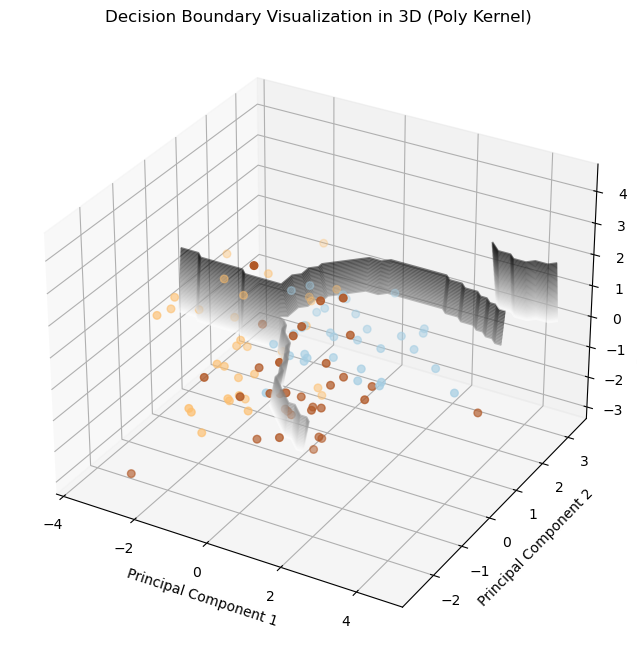

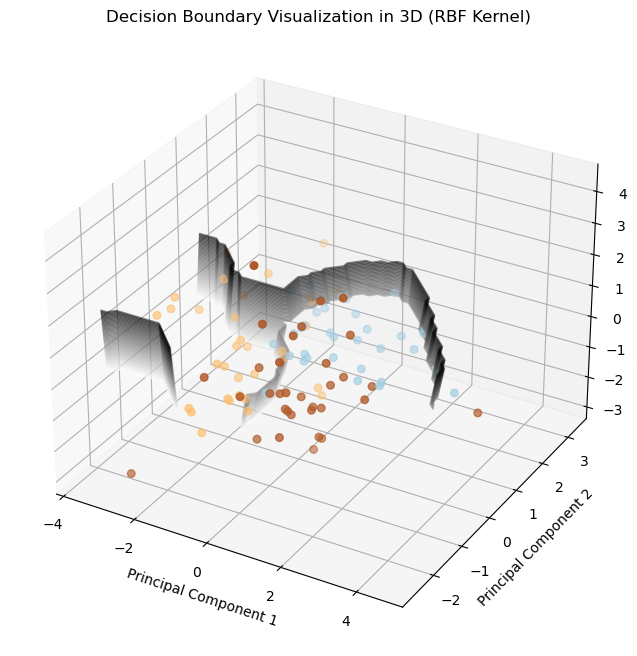

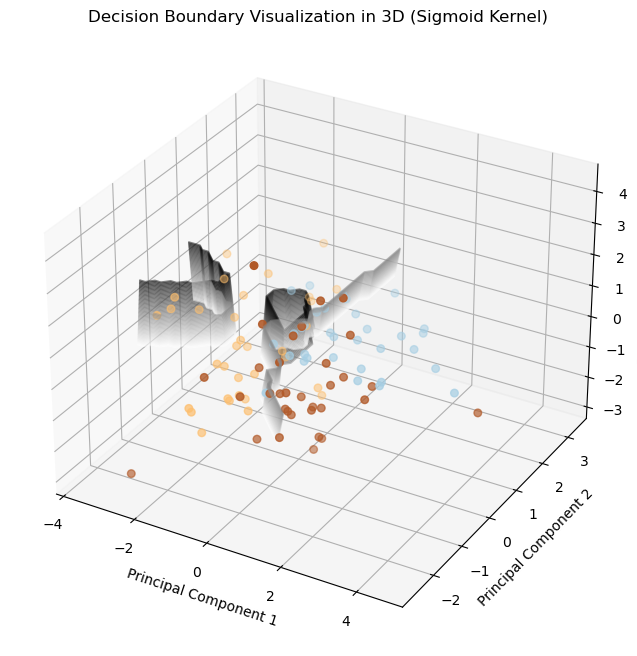

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=3, n_classes=3, n_clusters_per_class=1, 
                            n_informative=3, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM dengan kernel poly
svm_poly = SVC(kernel='poly', degree=3, coef0=1)
svm_poly.fit(X, y)

# Membuat model SVM dengan kernel rbf
svm_rbf = SVC(kernel='rbf', gamma='auto')
svm_rbf.fit(X, y)

# Membuat model SVM dengan kernel sigmoid
svm_sigmoid = SVC(kernel='sigmoid', coef0=1)
svm_sigmoid.fit(X, y)

# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=30)

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    plt.show()

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


### TRAIN 4 POLY

In [47]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True)
svc = SVC(kernel='poly', class_weight='balanced')
model = make_pipeline(pca, svc)

In [48]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.0001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 8min 40s
Wall time: 2min 36s
{'svc__C': 50, 'svc__gamma': 0.005}


In [49]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

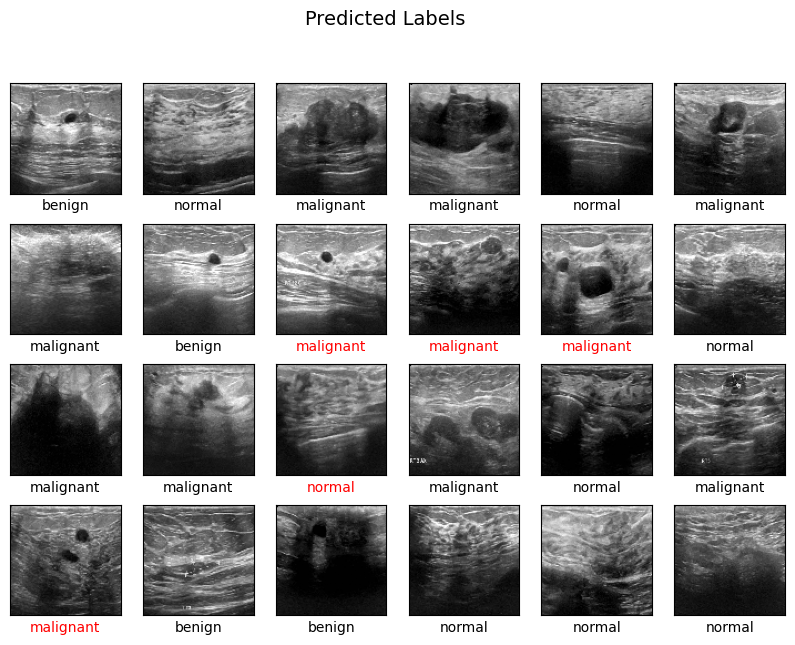

In [50]:
# Reshape the data back to the original shape
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 100, 100, 3))

# Visualize the predicted images
fig, ax = plt.subplots(4, 6, figsize=(10, 7))

for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest_reshaped[i], cmap='bone')  
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(f'{yfit[i]}', color='red' if yfit[i] != ytest[i] else 'black')

fig.suptitle('Predicted Labels', size=14)
plt.show()

In [51]:
# Periksa pembagian data pelatihan dan pengujian
print(f"Jumlah sampel data pelatihan: {len(ytrain)}")
print(f"Jumlah sampel data pengujian: {len(ytest)}")

Jumlah sampel data pelatihan: 957
Jumlah sampel data pengujian: 240


In [52]:
from sklearn.metrics import classification_report as sklearn_classification_report

def my_classification_report(ytest, yfit, classes):
    report = sklearn_classification_report(ytest, yfit, target_names=classes)
    print(report)

# Plot classification report for SVM
my_classification_report(ytest, model.predict(Xtest), classes=['benign', 'malignant', 'normal'])

              precision    recall  f1-score   support

      benign       0.97      0.42      0.59        80
   malignant       0.66      0.99      0.79        89
      normal       0.99      1.00      0.99        71

    accuracy                           0.80       240
   macro avg       0.87      0.80      0.79       240
weighted avg       0.86      0.80      0.78       240



In [53]:
print("Training Score:", model.score(Xtrain.reshape(Xtrain.shape[0], -1), ytrain))
print("Testing Score:", model.score(Xtest.reshape(Xtest.shape[0], -1), ytest))

Training Score: 0.9968652037617555
Testing Score: 0.8041666666666667


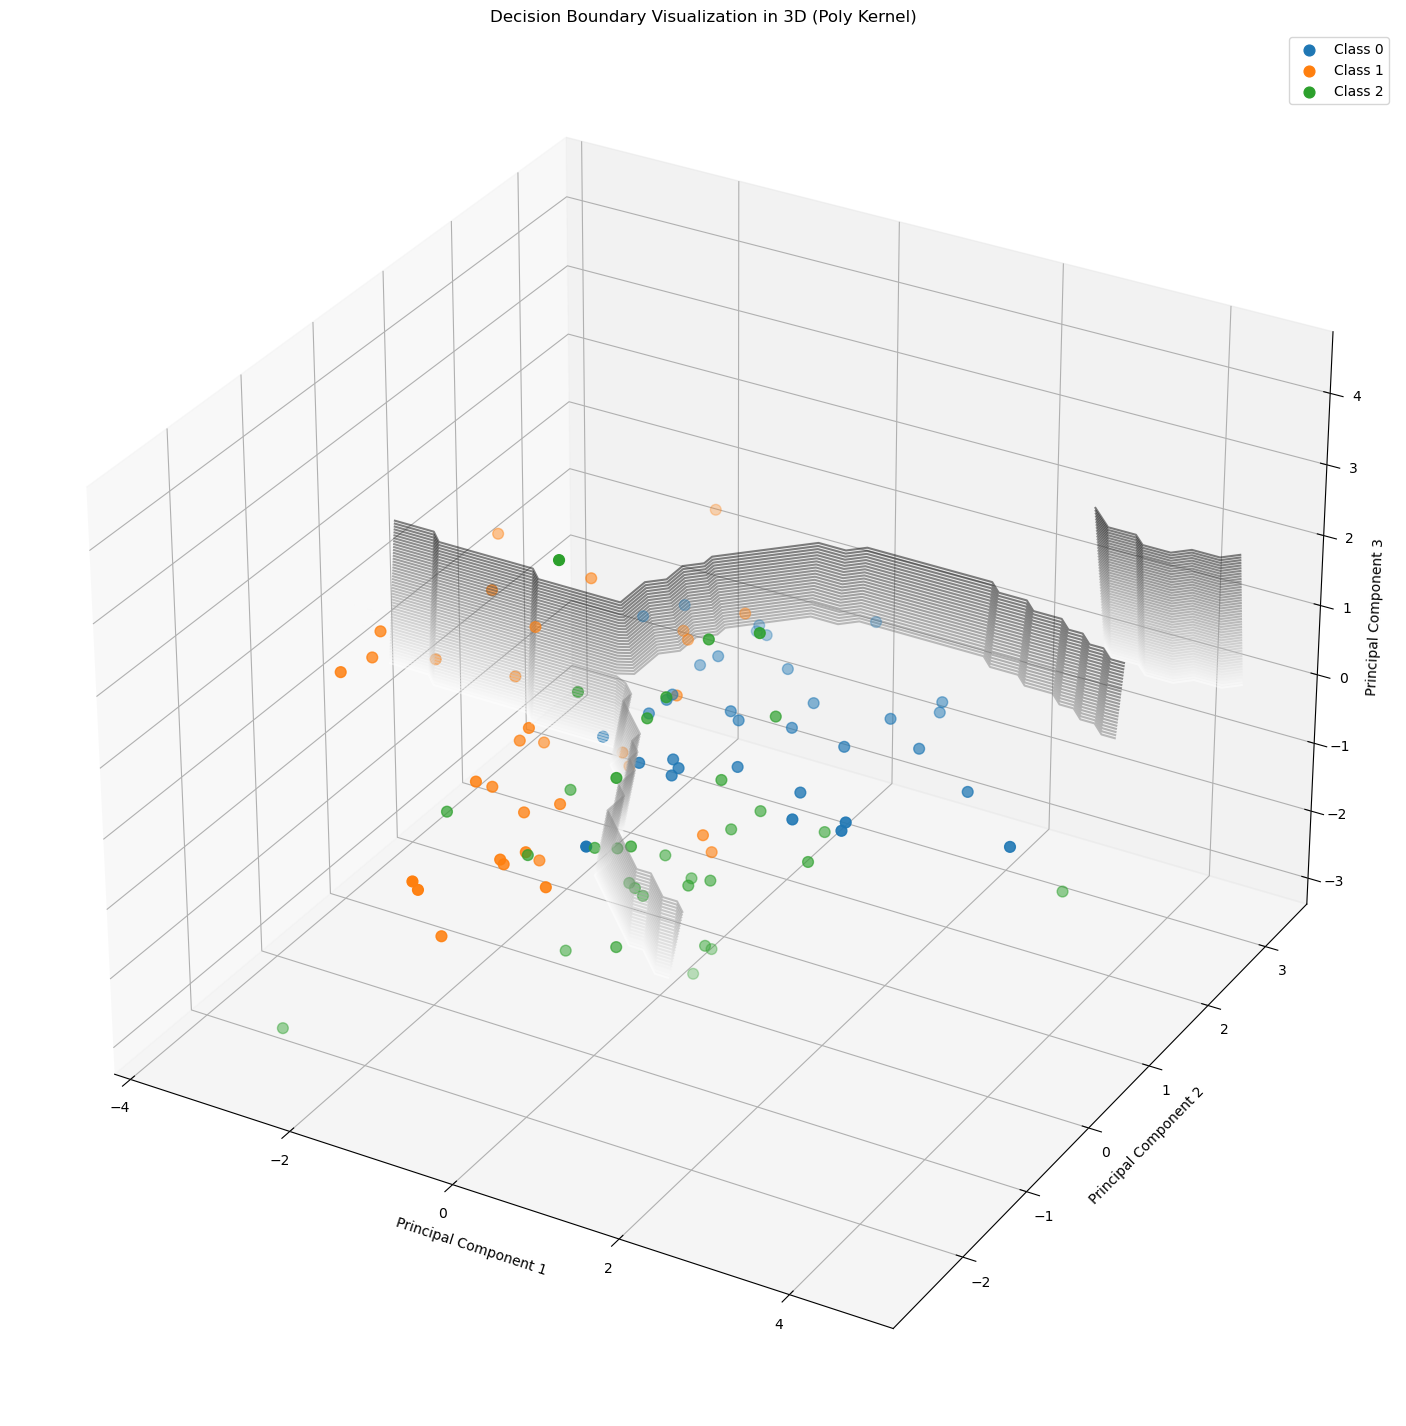

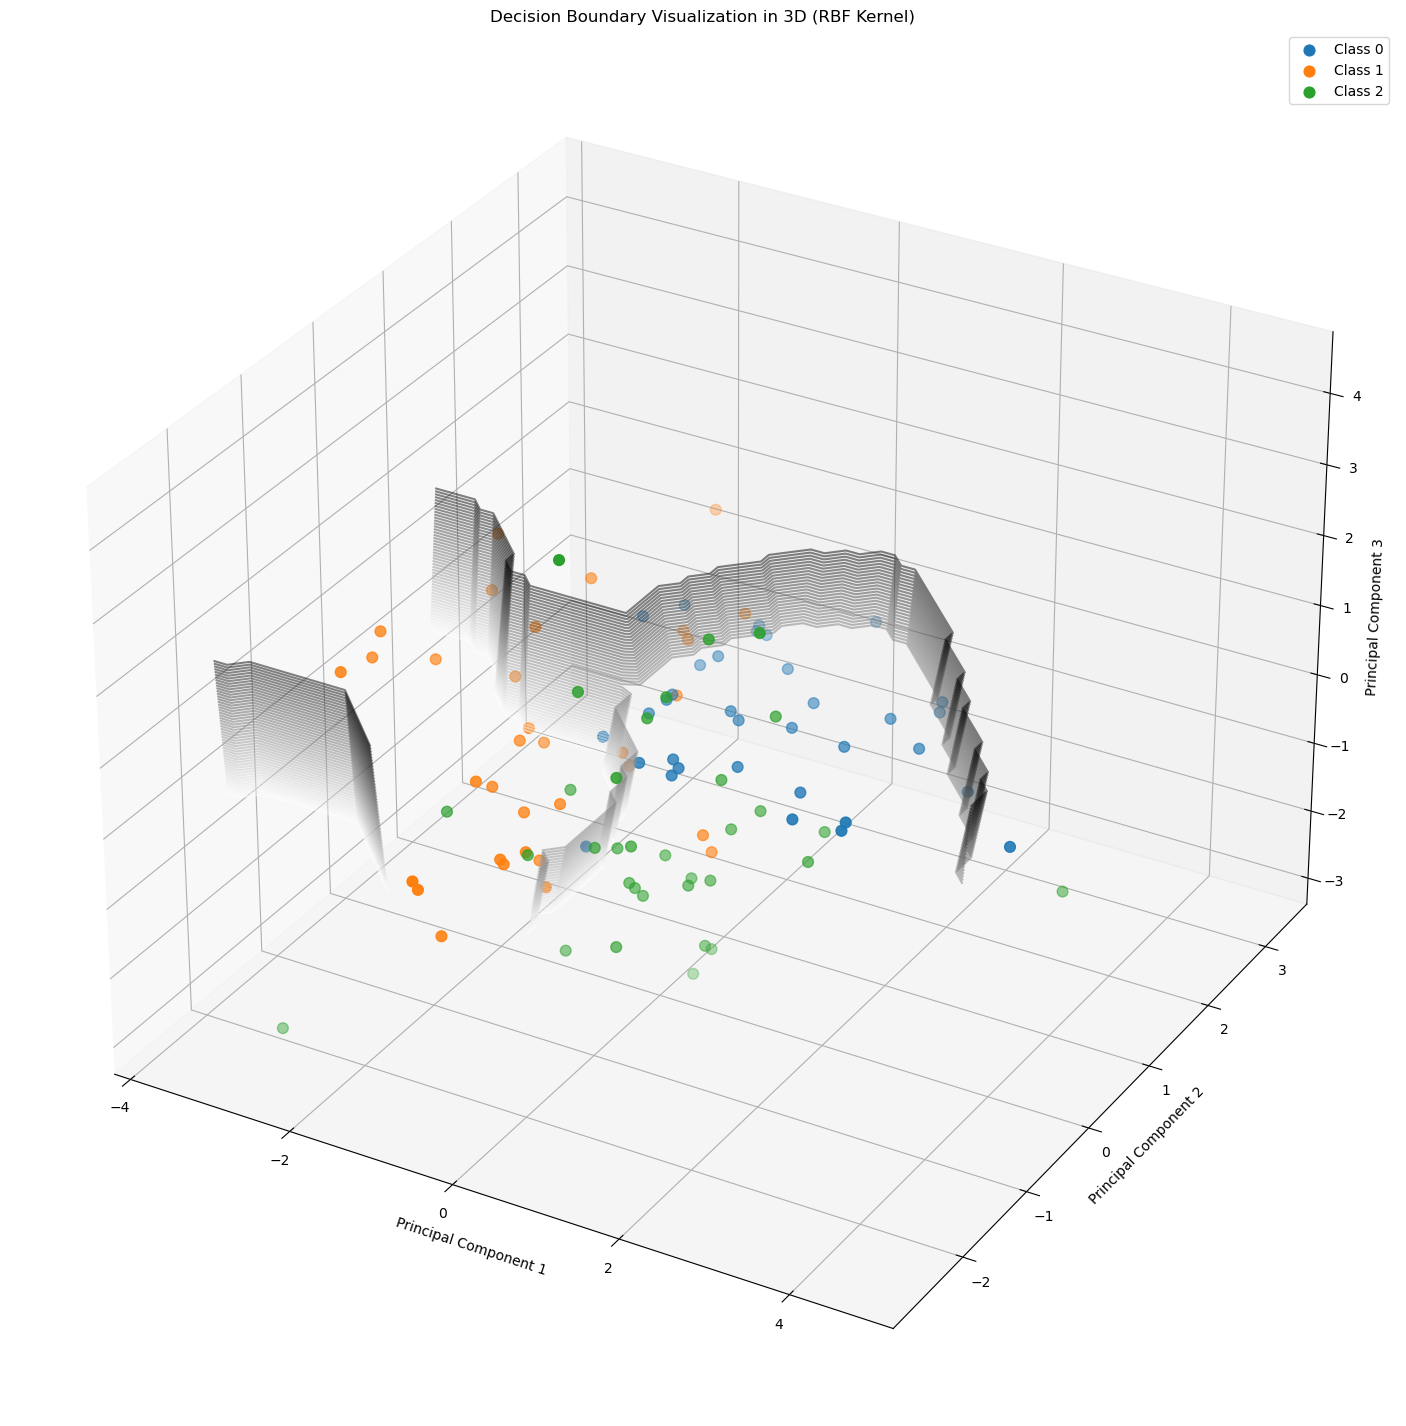

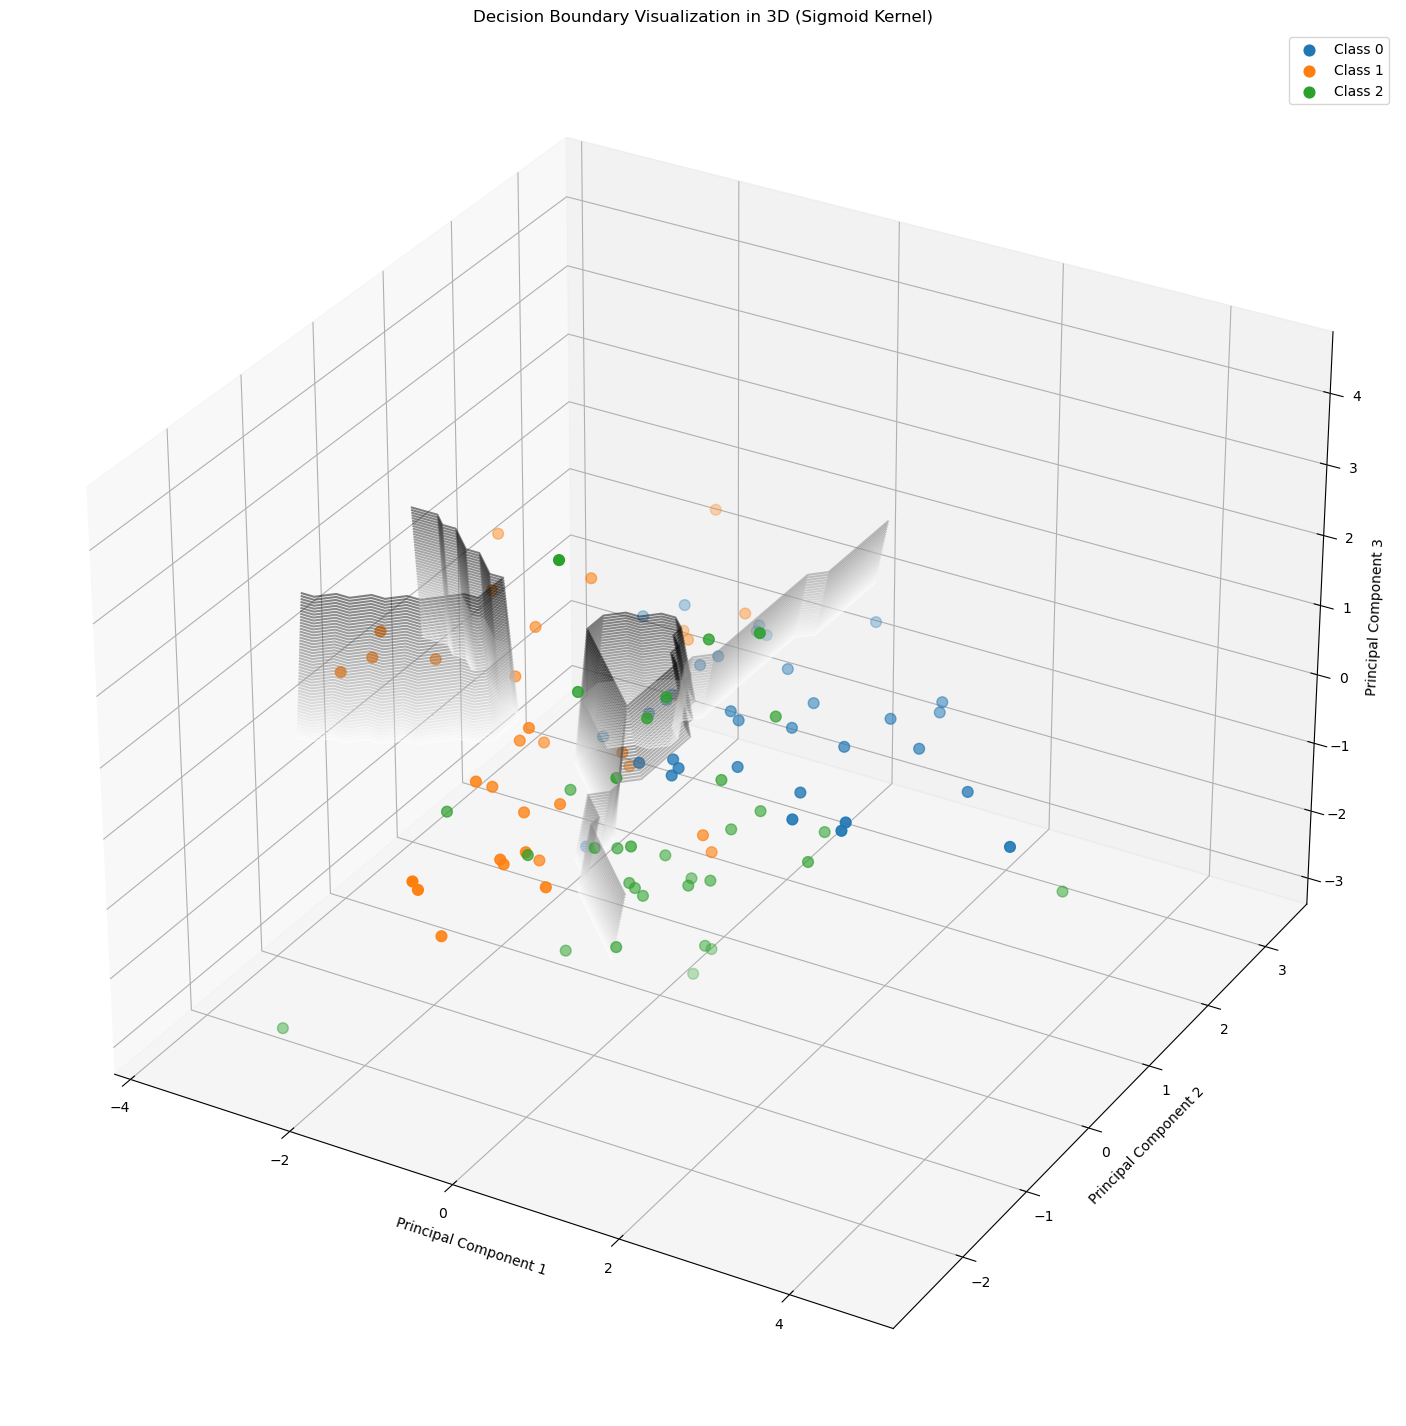

In [54]:
# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi dengan titik data yang jelas
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    for i in range(3):
        ax.scatter(X_pca[y==i, 0], X_pca[y==i, 1], X_pca[y==i, 2], cmap=plt.cm.Paired, s=60, label=f'Class {i}')

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


In [55]:
# Membuat fungsi untuk visualisasi batas keputusan dalam 3 dimensi dengan titik data yang jelas
def plot_decision_boundary_3d(X, y, clf, title):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Mengurangi dimensi data ke 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)

    # Plot data point
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap=plt.cm.Paired, s=60)

    # Plot batas keputusan
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    if clf.kernel == 'poly':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    elif clf.kernel == 'rbf':
        X_mesh = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())]
        Z = clf.predict(X_mesh)
    elif clf.kernel == 'sigmoid':
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    ax.contour3D(xx, yy, Z, 50, cmap='binary', alpha=0.5)

    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title(title)
    ax.legend(['Class 0', 'Class 1', 'Class 2'])  # Add legend
    plt.show()


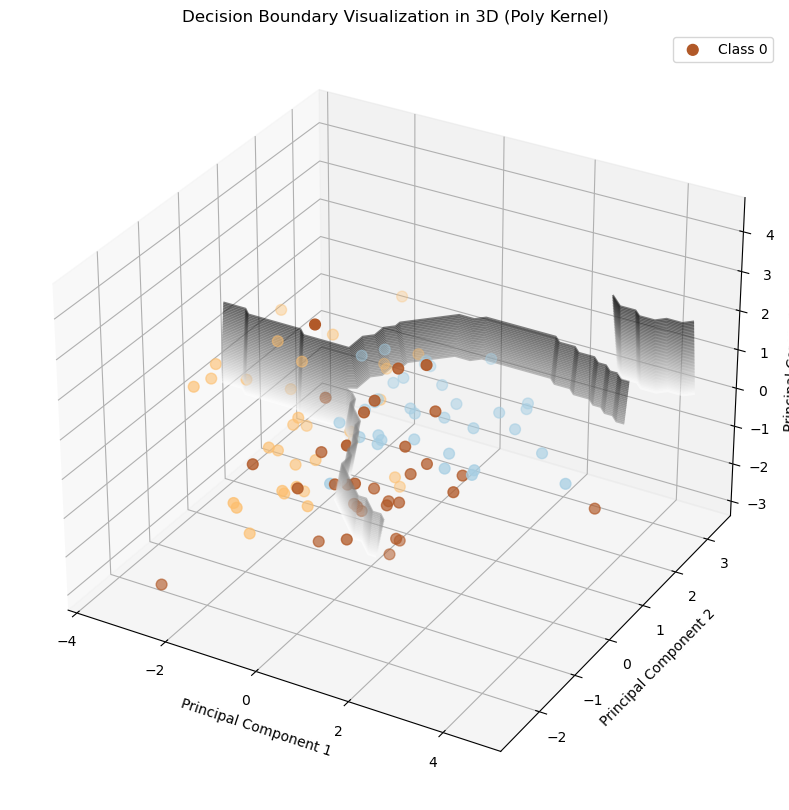

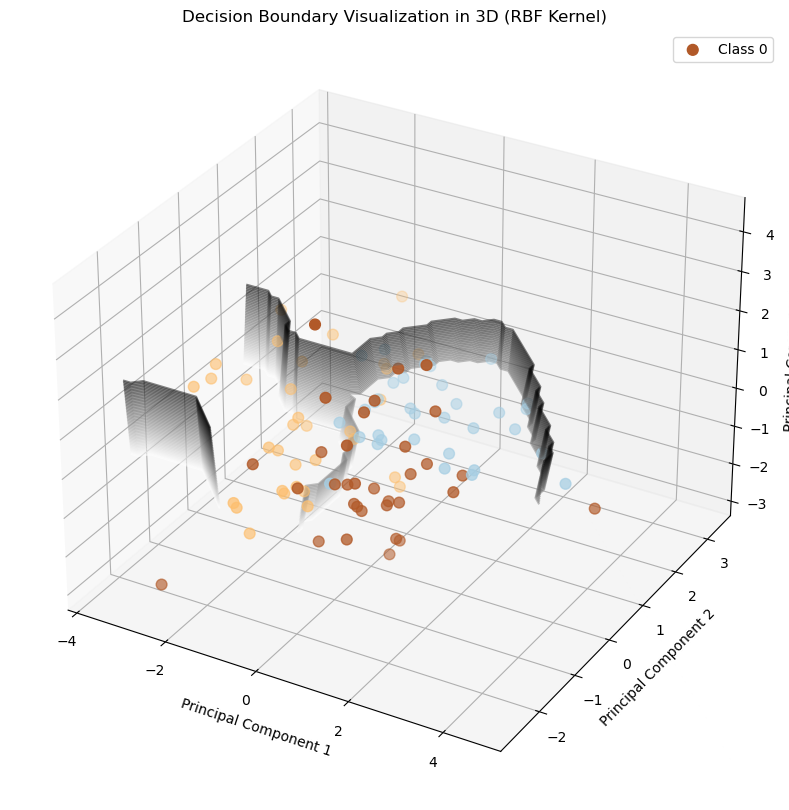

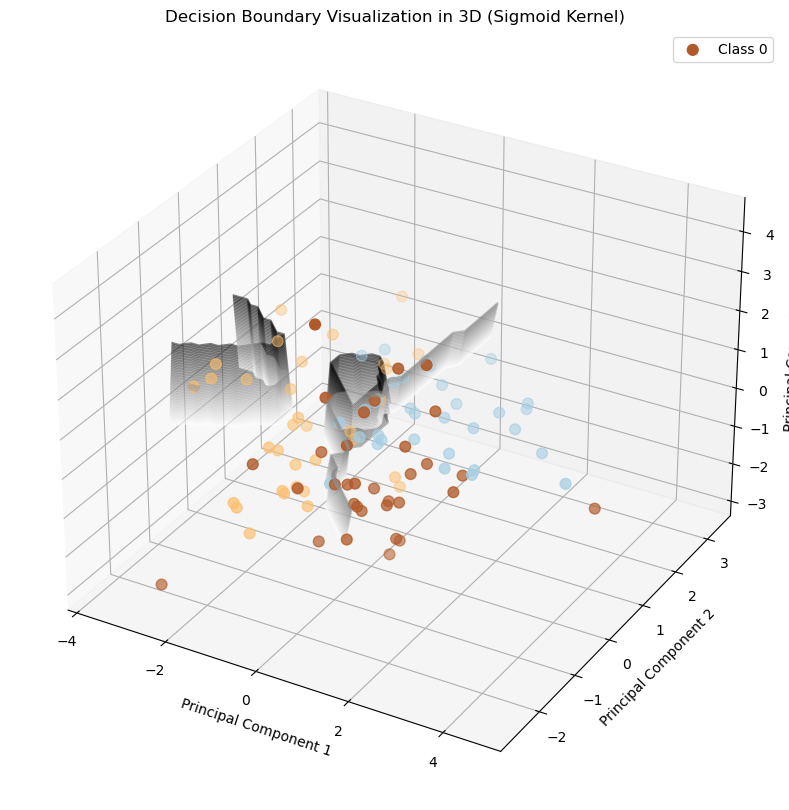

In [56]:
# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel poly
plot_decision_boundary_3d(X, y, svm_poly, 'Decision Boundary Visualization in 3D (Poly Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel rbf
plot_decision_boundary_3d(X, y, svm_rbf, 'Decision Boundary Visualization in 3D (RBF Kernel)')

# Memvisualisasikan batas keputusan dalam 3 dimensi untuk kernel sigmoid
plot_decision_boundary_3d(X, y, svm_sigmoid, 'Decision Boundary Visualization in 3D (Sigmoid Kernel)')


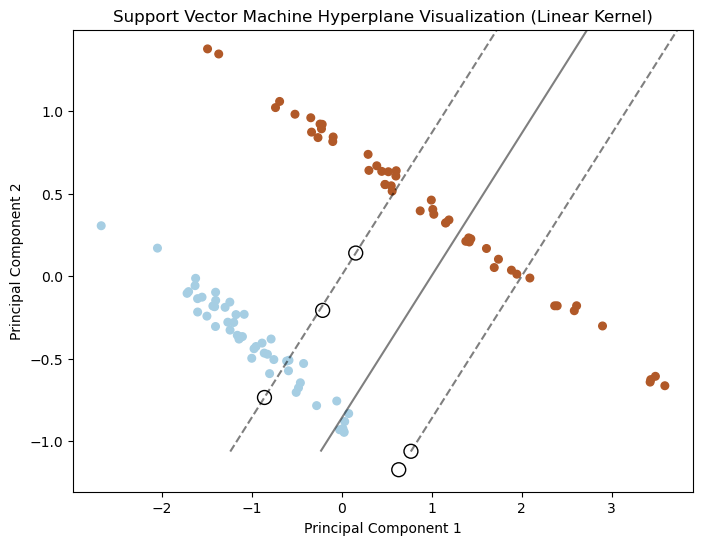

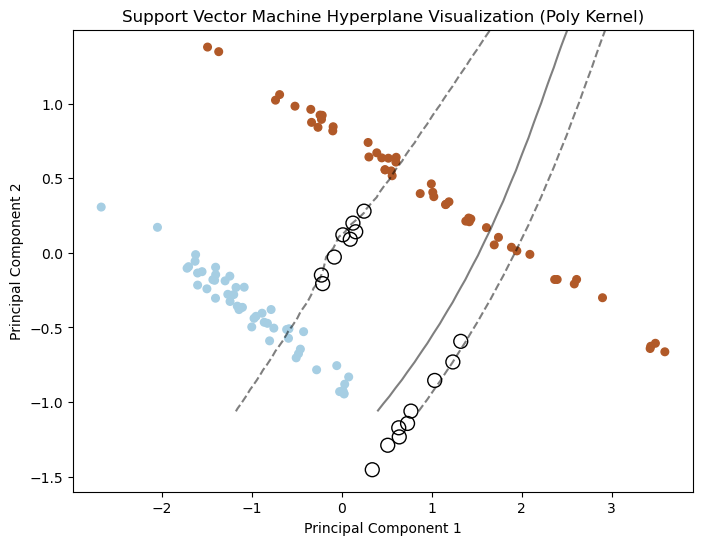

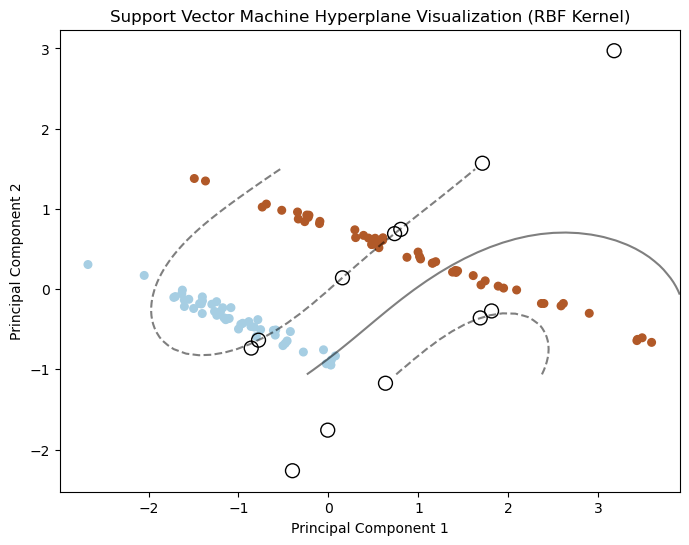

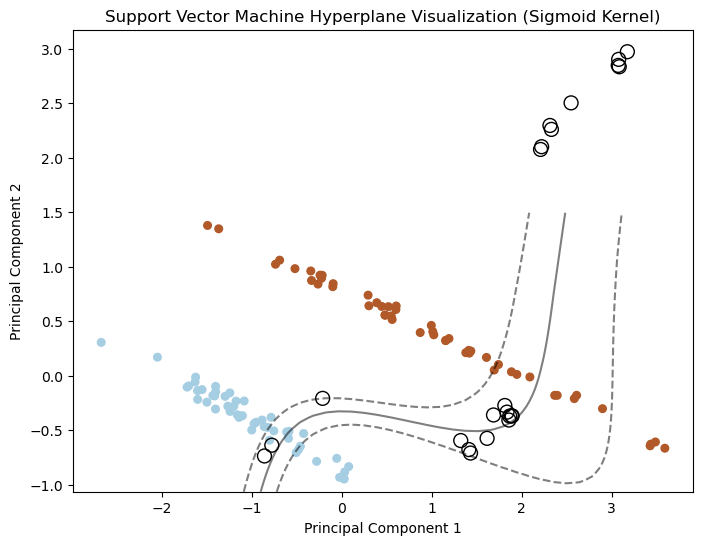

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification

# Membuat dataset sintetis
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, 
                            n_informative=2, n_redundant=0, n_repeated=0, random_state=42)

# Membuat model SVM dengan kernel linear
svm_linear = SVC(kernel='linear')
svm_linear.fit(X, y)

# Membuat model SVM dengan kernel poly
svm_poly = SVC(kernel='poly', degree=3)
svm_poly.fit(X, y)

# Membuat model SVM dengan kernel rbf
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X, y)

# Membuat model SVM dengan kernel sigmoid
svm_sigmoid = SVC(kernel='sigmoid')
svm_sigmoid.fit(X, y)

# Membuat fungsi untuk visualisasi hyperplane
def plot_hyperplane(X, y, clf, title):
    plt.figure(figsize=(8, 6))

    # Mengurangi dimensi data ke 2
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot data point
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot hyperplane
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Membuat grid untuk menggambar hyperplane
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Visualisasi hyperplane dan margin
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    # Menandai support vectors
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.show()

# Memvisualisasikan hyperplane untuk kernel linear
plot_hyperplane(X, y, svm_linear, 'Support Vector Machine Hyperplane Visualization (Linear Kernel)')

# Memvisualisasikan hyperplane untuk kernel poly
plot_hyperplane(X, y, svm_poly, 'Support Vector Machine Hyperplane Visualization (Poly Kernel)')

# Memvisualisasikan hyperplane untuk kernel rbf
plot_hyperplane(X, y, svm_rbf, 'Support Vector Machine Hyperplane Visualization (RBF Kernel)')

# Memvisualisasikan hyperplane untuk kernel sigmoid
plot_hyperplane(X, y, svm_sigmoid, 'Support Vector Machine Hyperplane Visualization (Sigmoid Kernel)')
